Notebook ini merupakan submission untuk modul NLP sebagai syarat melanjutkan modul kelas Belajar Pengembangan Machine Learning di Dicoding.

Pertama-tama, saya akan meng-import beberapa library yang dibutuhkan, diantaranya:
1. pandas: untuk membaca berkas CSV menjadi sebuah DataFrame.
2. matplotlib.pyplot: untuk melakukan plot loss dan akurasi model.
3. train_test_split: untuk membuat validation set.
4. Tokenizer: untuk melakukan tokenisasi.
5. pad_sequences: untuk melakukan padding sehingga sequence memiliki panjang yang sama.
6. Adamax: optimizer yang akan digunakan.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adamax

Pada submission ini, saya menggunakan dataset yang berisi review (ulasan) pada Google Play Store. Dataset didapatkan dari Kaggle pada link berikut: [Google Play Store Apps](https://www.kaggle.com/lava18/google-play-store-apps?select=googleplaystore_user_reviews.csv). Selanjutnya berkas CSV yang telah diunggah akan dibaca oleh pandas menjadi sebuah DataFrame.

In [ ]:
df = pd.read_csv('googleplaystore_user_reviews.csv')

Sebelum membuat model, kita perlu melakukan eksplorasi terhadap data sehingga kita memiliki pemahaman lebih mengenai data tersebut.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [ ]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


Terdapat beberapa data kosong, maka data yang mengandung `NaN` akan di-drop. Adapun terdapat 5 kolom pada DataFrame, sedangkan yang akan digunakan hanya kolom `Translated_Review` dan `Sentiment`, maka kolom lain akan di-drop juga.

In [ ]:
df = df.dropna()
df = df.drop(columns=['App', 'Sentiment_Polarity', 'Sentiment_Subjectivity'])

In [ ]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

Kolom `Sentiment` memuat 3 nilai unik, yaitu positif, negatif, dan netral. Selanjutnya saya akan melakukan One-Hot Encoding.

In [ ]:
category = pd.get_dummies(df.Sentiment)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Sentiment')
df_baru

,Translated_Review,Negative,Neutral,Positive
0,I like eat delicious food. That's I'm cooking ...,0,0,1
1,This help eating healthy exercise regular basis,0,0,1
3,Works great especially going grocery store,0,0,1
4,Best idea us,0,0,1
5,Best way,0,0,1
...,...,...,...,...
64222,Most ads older many agents ..not much owner po...,0,0,1
64223,"If photos posted portal load, fit purpose. I'm...",0,0,1
64226,"Dumb app, I wanted post property rent give opt...",1,0,0
64227,I property business got link SMS happy perform...,0,0,1


Langkah selanjutnya adalah menerapkan `train_test_split` pada data. Sesuai dengan kriteria, validation set sebesar 20% dari total dataset.

In [ ]:
ulasan = df_baru['Translated_Review'].values
label = df_baru[['Negative', 'Neutral', 'Positive']].values

In [ ]:
ulasan_latih, ulasan_test, label_latih, label_test = train_test_split(ulasan, label, test_size=0.2)

Kemudian saya akan melakukan tokenisasi dan padding.

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(ulasan_latih) 
tokenizer.fit_on_texts(ulasan_test)

sekuens_latih = tokenizer.texts_to_sequences(ulasan_latih)
sekuens_test = tokenizer.texts_to_sequences(ulasan_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

Sebelum membuat model, saya akan membuat callbacks terlebih dahulu yang nanti akan diterapkan ke model. Callbacks akan menghentikan proses training jika `val_accuracy` lebih dari 0.92.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc') > 0.92):
          print('\nval_accuracy telah mencapai lebih dari 92%.')
          self.model.stop_training = True
callbacks = myCallback()

NameError: ignored

Sekarang saatnya membuat model dan melakukan training, saya menerapkan Embedding dan LSTM.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adamax(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
history = model.fit(padded_latih, label_latih, epochs=30, 
                    validation_data=(padded_test, label_test), verbose=2, steps_per_epoch=250, callbacks=[callbacks])

Epoch 1/30
250/250 - 146s - loss: 0.8638 - accuracy: 0.6407 - val_loss: 0.7089 - val_accuracy: 0.6731
Epoch 2/30
250/250 - 149s - loss: 0.5379 - accuracy: 0.7718 - val_loss: 0.4373 - val_accuracy: 0.8305
Epoch 3/30
250/250 - 145s - loss: 0.3815 - accuracy: 0.8566 - val_loss: 0.3505 - val_accuracy: 0.8710
Epoch 4/30
250/250 - 145s - loss: 0.3009 - accuracy: 0.8924 - val_loss: 0.3170 - val_accuracy: 0.8838
Epoch 5/30
250/250 - 145s - loss: 0.2443 - accuracy: 0.9191 - val_loss: 0.2814 - val_accuracy: 0.9022
Epoch 6/30
250/250 - 150s - loss: 0.2103 - accuracy: 0.9337 - val_loss: 0.2682 - val_accuracy: 0.9068
Epoch 7/30
250/250 - 145s - loss: 0.1866 - accuracy: 0.9425 - val_loss: 0.2624 - val_accuracy: 0.9100
Epoch 8/30
250/250 - 146s - loss: 0.1682 - accuracy: 0.9495 - val_loss: 0.2404 - val_accuracy: 0.9200
Epoch 9/30

val_accuracy telah mencapai lebih dari 92%.
250/250 - 146s - loss: 0.1505 - accuracy: 0.9561 - val_loss: 0.2459 - val_accuracy: 0.9209


Terakhir saya akan membuat plot loss dan akurasi model.

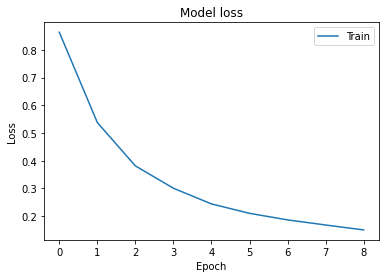

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

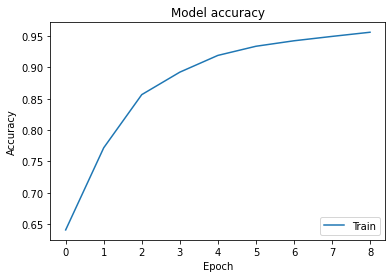

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [ ]:


plot_acc = [history.history['accuracy'], history.history['val_accuracy']]
plt.plot(range(len(plot_acc[0])), plot_acc[0], label='Training Accuracy')
plt.plot(range(len(plot_acc[1])), plot_acc[1], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

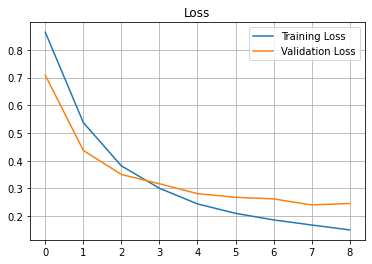

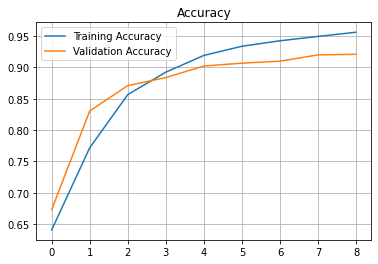

In [ ]:
plt_loss = [history.history['loss'],history.history['val_loss']]

plt.plot(range(len(plt_loss[0])), plt_loss[0], label='Training Loss')
plt.plot(range(len(plt_loss[1])), plt_loss[1], label='Validation Loss')
plt.title('Loss')
plt.grid(True)
plt.legend()
plt.show()

plt_acc = [history.history['accuracy'],history.history['val_accuracy']]

plt.plot(range(len(plt_acc[0])), plt_acc[0], label='Training Accuracy')
plt.plot(range(len(plt_acc[1])), plt_acc[1], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()